# Final Project Submission

Please fill out:
* Student name: Amanda Gaeta
* Student pace: part time
* Scheduled project review date/time: June 11th, 2020 at 12:45pm CST
* Instructor name: Lindsey Berlin

# Introduction

This notebook contains the most updated approach to this classification model. This V2 notebook applies the SpaCy package in the preprocessing step and leads to improvement in the goal metric of precision using an SVM.

If you are interested in previous iterations of this model involving a different approach to preprocessing utilizing:
- a tweet specific processing package 
- nltk 
- feature engineering beyond the tweet text

refer to Preprocessing_V1 notebook.

# Notebook Summary

### Business Case

#### Background
A marketing agency specializing in brand representation at large scale events/festivals (like SXSW) is building an internal tool to help manage social presence of major brands.

This project is the first step in building a base model to fuel auto-responses and amplification of positive tweets for their clients that will aid in social presence and positive interactions with the brand.

The agency invested in manually labelling these tweets positive/negative/neutral to support building the first model with the intention to build this dataset and predictiveness over time.

#### Metrics
Beyond the foundational goal of building a model with accuracy above a random guess, **the main goal in mind is to accurately label _positive tweets_; thus the model iteration focuses on maximizing precision scores**. This minimizes False Positives where a negative or neutral tweet is classified as positive and company amplifies promoting something that attendees view negatively about a brand. A False Positive would be more harmful than a False Negative where a positive tweet is classified as negative, and company misses opportunity to amplify messaging around something that customers view positively.

### WordCloud Visualizations/Data Exploration Pre-Modeling
- [Word Cloud iteration 1:](#WC_1)
Baseline visualization of positive versus neutral/negative tweets

- [Word Cloud iteration 2:](#WC_2)
Remove less meaningful, highly repetitive words/phrases like sxsw and circle announcement retweets (~250 records)

- [Word Cloud iteration 3:](#WC_3)
Look at unique tokens of positive versus negative/neutral tweets

### Models

**Baseline Testing with placeholders**
- [Model 1 - Naive Bayes + CountVec](#Model_1)

**Data Version 2 Testing no placeholders**
- [Model 2 - Naive Bayes + CountVec v2](#Model_2)
- [Model 3 - Naive Bayes  + TF-IDF](#Model_3)

**Data Version 2 Model Type testing**
- [Model 4 - Naive Bayes + TF-IDF (More Word Removal)](#Model_4)
- [Model 5 - Random Forest + TF-IDF](#Model_5)
- [Model 6 - SVM + TF-IDF](#Model_6)

**Winning Model**
- [Model 7 - Tuned SVM + TF-IDF](#Model_7)

**Conclusion**
- [Recommendations](#REC)
- [Future Work](#FW)

**Results**

The final model produced an accuracy score slightly higher than a baseline random guess at 69%, and more importantly a very high precision score at 91% with a mean 3-fold cross validation score of 87%. The F1 score was extremely low at 14%, further proving this model's pure focus on the precision metric versus recall.

This is a great result for this dataset, but in order to make this useful and more proven more data needs to be collected specifically on SXSW. This can be done by using Twitter API to scrape tweets. Further scale can be applied by scraping tweets for additional events the agency's clients/brands are represented at.

Additional consideration should be applied to other uses for this data including focus on a more interpretable model type. This approach would aid in understanding the specific characteristics of positive sentiment within tweet language and could be applied better at a strategic level to plan what to invest in for future events.

### Imports

In [62]:
#Basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Language processing
import re #regex
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, f1_score

In [63]:
# Import file
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df = raw_data.copy()

# Preview file 
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [64]:
# Overview file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


### Functions

In [65]:
# Thanks to my Flatiron DS teacher, Lindsey Berlin, for the base
# code.
def eval_model_vectorized_text(vectorizer, classifier, X_train, X_test, y_train, y_test):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs (Prints): 
    Train and Text Scores:
    - Accuracy
    - Precision
    - Precision Cross Val 3-Fold
    - F1
    '''

    X_train_transformed = vectorizer.fit_transform(X_train) # learning corpus of training data (holistic)
    X_test_transformed = vectorizer.transform(X_test) # new words only in test set won't impact

    classifier.fit(X_train_transformed, y_train)

    train_preds = classifier.predict(X_train_transformed)
    test_preds = classifier.predict(X_test_transformed)

    print('Train Scores')
    print(f'Accuracy:{accuracy_score(y_train, train_preds)}')
    print(f'Precision:{precision_score(y_train, train_preds)}')
    print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(classifier, X_train_transformed, y_train, cv=3, scoring='precision'))}")
    print(f'F1 Score:{f1_score(y_train, train_preds)}')
    print('--------')
    print('Test Scores')
    print(f'Accuracy:{accuracy_score(y_test, test_preds)}')
    print(f'Precision:{precision_score(y_test, test_preds)}')
    print(f"Precision Mean Cross Val 3-Fold: {np.mean(cross_val_score(classifier, X_train_transformed, y_train, cv=3, scoring='precision'))}")
    print(f'F1 Score:{f1_score(y_test, test_preds)}')
    plot_confusion_matrix(classifier, X_test_transformed, y_test,
                          values_format=".4g")  # to make numbers readable
    plt.show()

### Data Exploration and Early Feature Engineering

Checked:
- value counts
- nulls
- class balance

Created:
- target (positive tweets versus netural/negative tweets) for classification model

In [66]:
# Fill nulls
df['emotion_in_tweet_is_directed_at'].fillna('None', inplace=True)

In [67]:
# drop row 6, tweet_text null row; 9092 row is foreign characters
df.drop(labels=[6, 9092], axis=0, inplace=True)

# reset index post drop
df = df.reset_index(drop=True)

In [68]:
# Value counts exploration
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5387
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [69]:
# Filter down emotions to Neutral
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"No emotion toward brand or product" : "Neutral",
                                                                                                                         "Positive emotion": "Positive",
                                                                                                                         "Negative emotion": "Negative",
                                                                                                                         "I can't tell": "Neutral"})

In [70]:
# Check value counts
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Neutral     5543
Positive    2978
Negative     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [71]:
# Create target; Positive only - 32%
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"Positive": 1,
                                                                             "Neutral": 0,
                                                                             "Negative": 0})

In [72]:
# Check work
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 4 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       9091 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
target                                                9091 non-null int64
dtypes: int64(1), object(3)
memory usage: 284.2+ KB


### Preprocessing

This is main place where Preprocessing_V1 and Preprocessing_V2 differ including the approach to twitter specific language parsing and tools used to tokenize.

#### Tasks done in this section:
- Replace hashtags, links, rt, and "@mention" with placeholders

Use Regex to:
- remove HTML, punctuation
- remove stop words

Use SpaCy to:
- tokenize tweets

Use nltk to:
- lemmatize tweets

#### Additional columns created to preserve data in various preprocessing iterations
- 'clean_tweet' column for tweet text that has undergone the placeholder placement and removals
- 'token_tweet' for tokenized version of 'clean_tweet'
- 'clean_token_tweet' for lemmatized version of 'token_tweet'

In [73]:
# Createw new column for cleaned tweet text
df['clean_tweet'] = df['tweet_text'].copy()

In [74]:
# Replace hashtags, links, rt, and "@mention" with placeholders (ph)
df['clean_tweet'] = df['clean_tweet'].replace({'#':'hashph',
                                              'http':'linkph',
                                              '{link}':'linkph',
                                               'RT':'rtph',
                                               '@mention':'menph'},
                                               regex=True)

# Account for mentions that do not have '@mention' in the original text and have usernames
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'@\w+', 'menph', (x)))

In [75]:
# How many tweets have these placeholders/tweet features
placeholders = ['hashph', 'linkph', 'rtph', 'menph']

for placeholder in placeholders:
    percent_tweets = round(((len(df[df['clean_tweet'].str.contains(placeholder)])/len(df))*100), 2)
    print(f'{percent_tweets}% with {placeholder}')
# Almost all contain hashtags
# More than half have mentions
# Less than half have links

99.93% with hashph
46.12% with linkph
29.55% with rtph
54.1% with menph


#### Cleaning html, removing punctuation, removing stopwords, lowercasing

In [76]:
# Clean 'clean_tweet' column of HTML; there were things like &quot
html_ent_clean = re.compile('&.*?;')
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(html_ent_clean, '',x))

# Remove punctuation
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

# Source: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

In [77]:
# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Remove stopwords
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

# Source: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [78]:
# Lowercase text
df['clean_tweet'] = df['clean_tweet'].str.lower()

In [79]:
df['clean_tweet']

0       menph 3g iphone 3 hrs tweeting hashphrise_aust...
1       menph know menph awesome ipadiphone app youll ...
2                 menph wait hashphipad 2 sale hashphsxsw
3       menph hope years festival isnt crashy years ip...
4       menph great stuff fri hashphsxsw marissa mayer...
                              ...                        
9086    menph yup dont app im android suggestions hash...
9087                               ipad hashphsxsw linkph
9088    wave buzz rtph menph interrupt regularly sched...
9089    googles zeiger physician reported potential ae...
9090    verizon iphone customers complained time fell ...
Name: clean_tweet, Length: 9091, dtype: object

#### Tokenize

In [80]:
# Create new column for tokenized tweets - SpaCy is faster and more accurate than NLTK
df['token_tweet'] = ""

In [81]:
# Create function to tokenize with spacy
def tokenize_tweet(tweet):
    my_tweet = nlp(tweet) 
    token_list = []
    for token in my_tweet:
        token_list.append(token.text)
    return token_list

In [82]:
# Create token tweet values
df['token_tweet'] = df['clean_tweet'].apply(tokenize_tweet)

In [83]:
# Preview new column
df['token_tweet']

0       [menph, 3, g, iphone, 3, hrs, tweeting, hashph...
1       [menph, know, menph, awesome, ipadiphone, app,...
2          [menph, wait, hashphipad, 2, sale, hashphsxsw]
3       [menph, hope, years, festival, is, nt, crashy,...
4       [menph, great, stuff, fri, hashphsxsw, marissa...
                              ...                        
9086    [menph, yup, do, nt, app, i, m, android, sugge...
9087                           [ipad, hashphsxsw, linkph]
9088    [wave, buzz, rtph, menph, interrupt, regularly...
9089    [googles, zeiger, physician, reported, potenti...
9090    [verizon, iphone, customers, complained, time,...
Name: token_tweet, Length: 9091, dtype: object

#### Lemmatize

In [84]:
# Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['token_tweet'] = df['token_tweet'].apply(lemmatize_text)

# Rejoin in new column
df['clean_token_tweet'] = df['token_tweet'].map(lambda x: ' '.join(x))

# Source: https://stackoverflow.com/questions/59567357/lemmatize-tokenised-column-in-pandas

In [85]:
# Preview new column 
df['clean_token_tweet']

0       menph 3 g iphone 3 hr tweeting hashphrise_aust...
1       menph know menph awesome ipadiphone app you ll...
2                 menph wait hashphipad 2 sale hashphsxsw
3       menph hope year festival is nt crashy year iph...
4       menph great stuff fri hashphsxsw marissa mayer...
                              ...                        
9086    menph yup do nt app i m android suggestion has...
9087                               ipad hashphsxsw linkph
9088    wave buzz rtph menph interrupt regularly sched...
9089    google zeiger physician reported potential ae ...
9090    verizon iphone customer complained time fell h...
Name: clean_token_tweet, Length: 9091, dtype: object

In [86]:
# Review df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 7 columns):
tweet_text                                            9091 non-null object
emotion_in_tweet_is_directed_at                       9091 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9091 non-null object
target                                                9091 non-null int64
clean_tweet                                           9091 non-null object
token_tweet                                           9091 non-null object
clean_token_tweet                                     9091 non-null object
dtypes: int64(1), object(6)
memory usage: 497.3+ KB


### WordCloud Visualization

#### Word Cloud iteration 1:<a id="WC_1"></a>
Baseline exploration of positive versus neutral/negative tweet language 

In [87]:
# New column removing placeholders for word cloud since earlier numbers showed high %
# of tweets with hashtags, links, etc that will not prove valuable in this graphic
df['clean_token_tweet_noph'] = df['clean_token_tweet'].replace({'hashph':'',
                                                                'linkph':'',
                                                                'rtph':'',
                                                                'menph':''},
                                                               regex=True)

In [88]:
positive_tweet_text_wc = df[df['target'] == 1]['clean_token_tweet_noph']
neut_neg_tweet_text_wc = df[df['target'] == 0]['clean_token_tweet_noph']

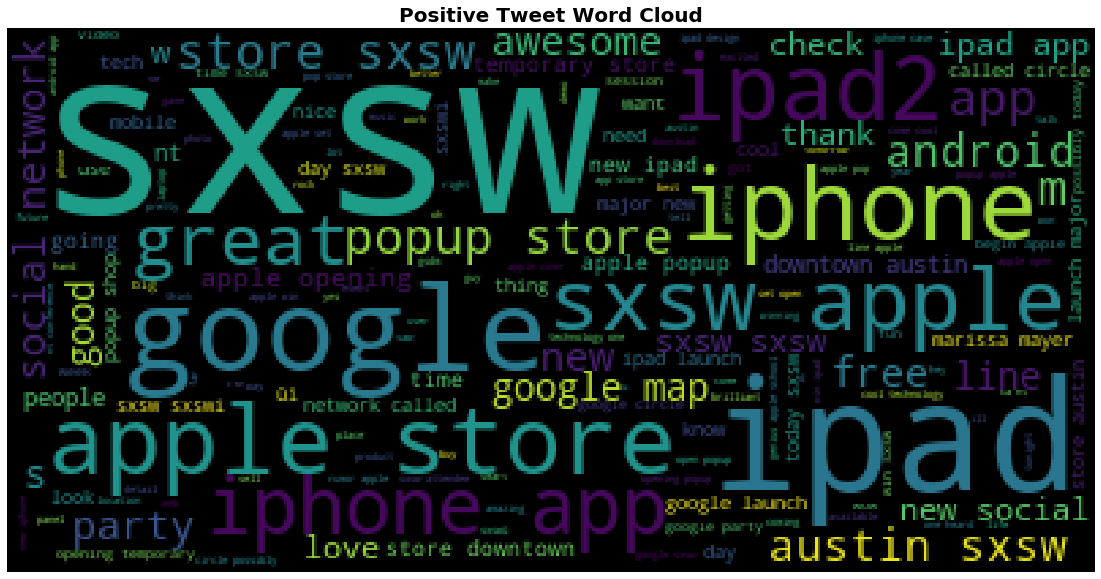

In [89]:
# Positive wordcloud
wordcloud = WordCloud().generate(' '.join(positive_tweet_text_wc))
# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive Tweet Word Cloud", fontsize=20, fontweight="bold")
plt.savefig("images/5_wc_positive_noph")
plt.show()
# Looks like there may be imbalance in brand represenation (apple versus google as words)
# Apple products largely mentioned over brand
# Looks like apple pop up/apple opening is represented
# More Apple product representation (ipad, iphone, ipad2, iphone app)

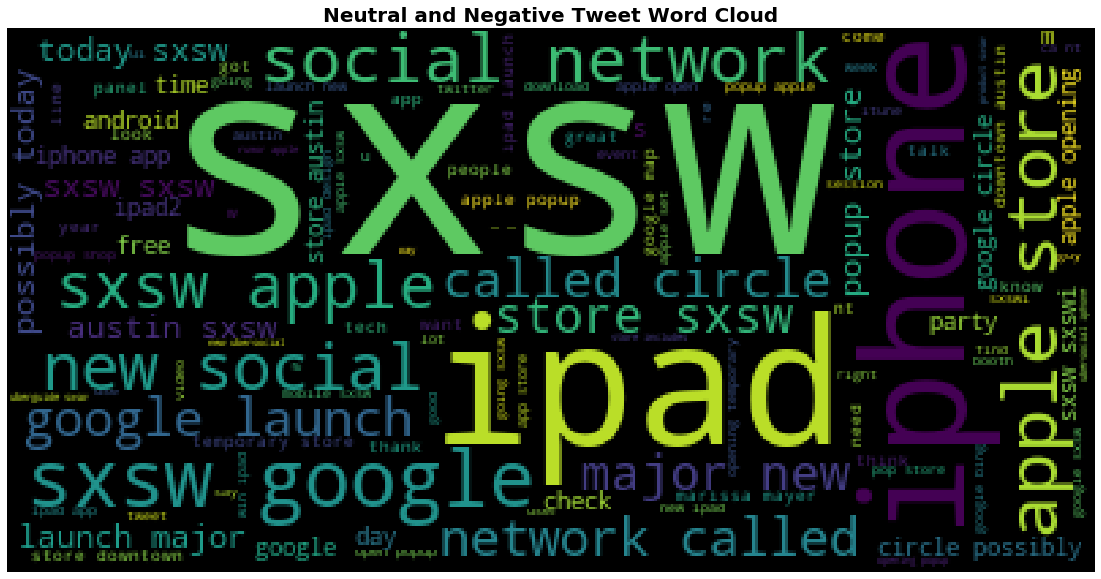

In [90]:
# Neutral/Negative wordcloud
wordcloud = WordCloud().generate(' '.join(neut_neg_tweet_text_wc))
# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Neutral and Negative Tweet Word Cloud", fontsize=20, fontweight="bold")
plt.savefig("images/6_wc_neut_neg_noph")
plt.show()
# sxsw major word like in positive
# iphone, ipad also in neutral/negative
# apple store negative
# google's social network launch of circles, bigrams look like high concentration of circles tweet

In [91]:
len(df[df['tweet_text'].str.contains('Social Network Called Circles')])
# 260 tweets RT'ing/mentioning article about Circles Launch

260

#### Word Cloud iteration 2:<a id="WC_2"></a>
Remove less meaningful, highly repetitive words/phrases like sxsw and circle announcement retweets (~250 records)

In [92]:
# Remove these, so word cloud is more representative
df['clean_token_tweet_edit_postwc'] = df['clean_token_tweet_noph'].replace({'Social Network Called Circles':'',
                                                                           'sxsw':''},
                                                                           regex=True)

In [93]:
positive_tweet_text_wc2 = df[df['target'] == 1]['clean_token_tweet_edit_postwc']
neut_neg_tweet_text_wc2 = df[df['target'] == 0]['clean_token_tweet_edit_postwc']

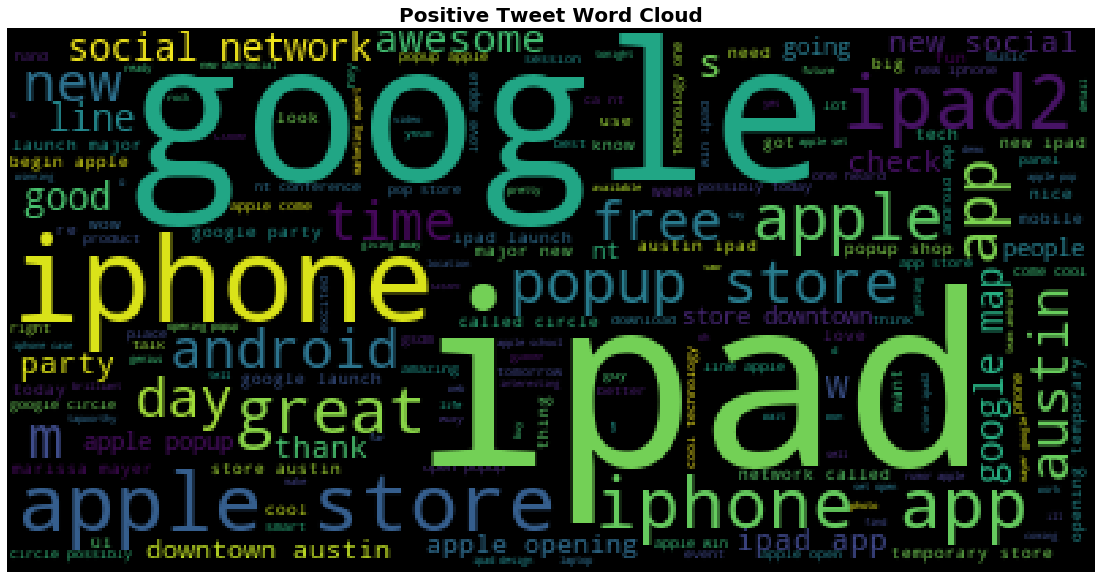

In [94]:
# Positive wordcloud
wordcloud = WordCloud().generate(' '.join(positive_tweet_text_wc2))
# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive Tweet Word Cloud", fontsize=20, fontweight="bold")
plt.savefig("images/7_wc_edited_positive_noph")
plt.show()
# Apple pop up store
# Google social network still represented

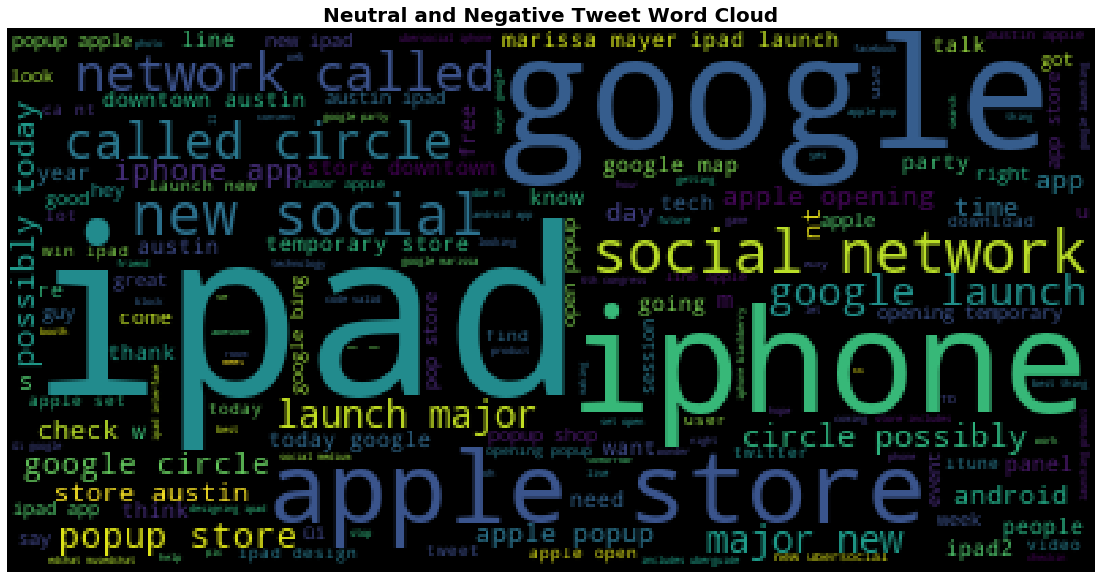

In [95]:
# Neutral/Negative wordcloud
wordcloud = WordCloud().generate(' '.join(neut_neg_tweet_text_wc2))
# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Neutral and Negative Tweet Word Cloud", fontsize=20, fontweight="bold")
plt.savefig("images/8_wc_edited_neut_neg_noph")
plt.show()
# Google social network still represented

#### Word Cloud iteration 3<a id="WC_3"></a>
Look at unique tokens of positive versus negative/neutral tweets

In [96]:
positive_tweet_text = df[df['target'] == 1]['token_tweet']
neut_neg_tweet_text = df[df['target'] == 0]['token_tweet']

In [97]:
pos_token_list = []

for tweet in positive_tweet_text:
    for token in tweet:
        pos_token_list.append(token)
        
pos_token_list_set = set(pos_token_list)
        
len(pos_token_list_set)

5042

In [98]:
neut_neg_token_list = []

for tweet in neut_neg_tweet_text:
    for token in tweet:
        neut_neg_token_list.append(token)

neut_neg_token_list_set = set(neut_neg_token_list)
        
len(neut_neg_token_list_set)
# 60% more neut_neg tokens than positive

8069

In [99]:
pos_token_list_unique = pos_token_list_set.difference(neut_neg_token_list_set)
# new set with elements in pos_token_list_set but not in neut_neg_token_list_set
len(pos_token_list_unique)

1861

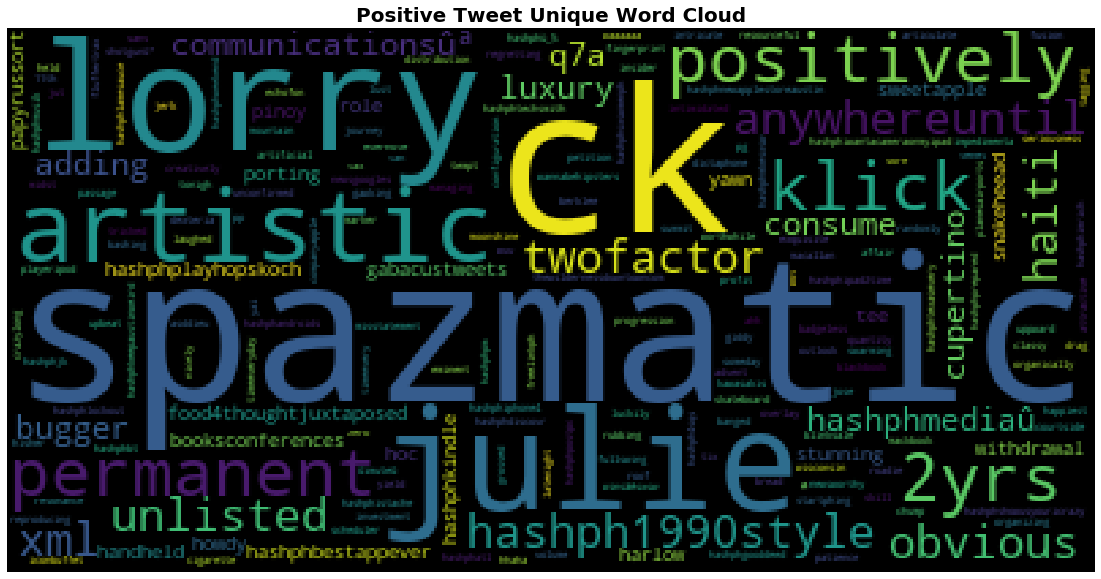

In [100]:
# Wordcloud of positive tweet unique words
wordcloud = WordCloud().generate(' '.join(pos_token_list_unique))
# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive Tweet Unique Word Cloud", fontsize=20, fontweight="bold")
plt.savefig("images/9_wc_positive_unique")
plt.show()
# Look up spazmatic 

In [101]:
df[df['clean_token_tweet'].str.contains('spazmatic')]['clean_token_tweet']
# Looks like google aclu party has Spazmatics 80s cover band performed
# 5 tweets and took over wordcloud

2591    google aclu party tonight hashphsxsw best thin...
6430    rtph menph p menph google throw btchin party s...
6739    rtph menph google aclu party tonight hashphsxs...
7911    80 theem google party spazmatic killn stage ho...
8507    p menph google throw btchin party shout spazma...
Name: clean_token_tweet, dtype: object

In [102]:
df[df['clean_token_tweet'].str.contains('usurped')]['clean_token_tweet']
# Joke tweet was retweeted once "ironic tee usurped ipad 2 hipstergeekstartup chic fashion item year"
# Showing how easy it is to sway the wordcloud. 2 mentions and it is one of top words

2310    ironic tee usurped ipad 2 hipstergeekstartup c...
6752    rtph menph ironic tee usurped ipad 2 hipsterge...
Name: clean_token_tweet, dtype: object

In [103]:
neut_neg_token_list_unique = neut_neg_token_list_set.difference(pos_token_list_set)
# new set with elements in neut_neg_token_list_set but not in pos_token_list_set
len(neut_neg_token_list_unique)
# 2.5x the number of unique tokens for neut_neg tweets
# 27% of unique tokens are positive (less than 67/33 split of tweets)

4888

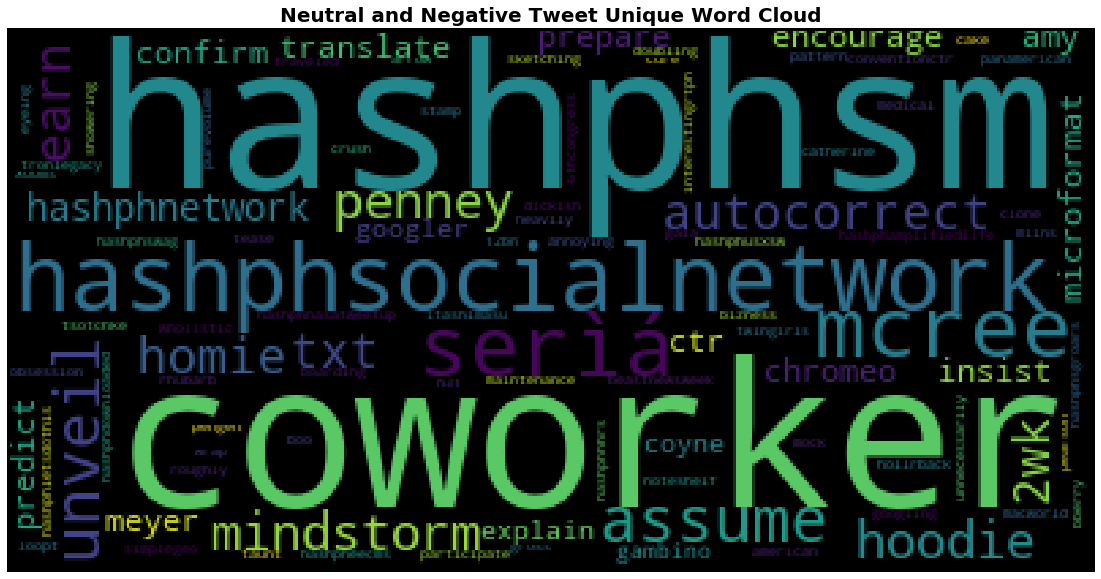

In [104]:
# Wordcloud of neutral/negative unique words
wordcloud = WordCloud().generate(' '.join(neut_neg_token_list_unique))
# Generate plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Neutral and Negative Tweet Unique Word Cloud", fontsize=20, fontweight="bold")
plt.savefig("images/10_wc_neut_neg_unique")
plt.show()

## Modeling

#### Model 1: Naive Bayes + CountVec<a id="Model_1"></a>

In [105]:
# Grabbing inputs and target
X = df['clean_tweet']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [106]:
# Instantiating a count vectorizer
countvec = CountVectorizer(ngram_range=(1,2),
                          max_df = .95, # removes words that appear in more than 95% of docs
                           min_df = 2)

# Trying Naive Bayes
nb = MultinomialNB()

Train Scores
Accuracy:0.856849515987093
Precision:0.7573135558302431
Precision Mean Cross Val 3-Fold: 0.5370355804783671
F1 Score:0.7901977644024076
--------
Test Scores
Accuracy:0.6924769027716674
Precision:0.5339195979899497
Precision Mean Cross Val 3-Fold: 0.5370355804783671
F1 Score:0.5487411233053583


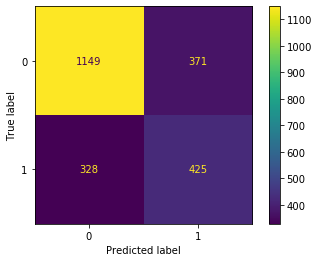

In [107]:
eval_model_vectorized_text(countvec, nb, X_train, X_test, y_train, y_test)
# overfit, big difference in precision

#### Model 2: Naive Bayes + CountVec v2<a id="Model_2"></a>
Change X to token tweets and remove placeholders

In [108]:
# Grabbing inputs and target
X = df['clean_token_tweet_noph']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Train Scores
Accuracy:0.8481959518920504
Precision:0.7412814274128142
Precision Mean Cross Val 3-Fold: 0.5324939152883726
F1 Score:0.7793647409933915
--------
Test Scores
Accuracy:0.6968763748350199
Precision:0.5396039603960396
Precision Mean Cross Val 3-Fold: 0.5324939152883726
F1 Score:0.558616271620756


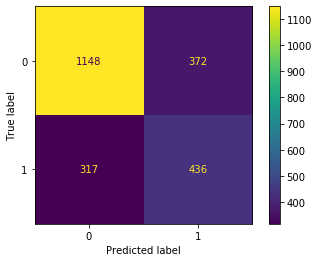

In [109]:
eval_model_vectorized_text(countvec, nb, X_train, X_test, y_train, y_test)
# similar output, lower on most scores

#### Model 3: Naive Bayes  + TF-IDF<a id="Model_3"></a>
Keep X without placeholders

In [110]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2,   # removes words that appear 2 or fewer times
                        use_idf=True) 

Train Scores
Accuracy:0.797741273100616
Precision:0.8953271028037383
Precision Mean Cross Val 3-Fold: 0.6750635989201162
F1 Score:0.5814871016691958
--------
Test Scores
Accuracy:0.7153541575010999
Precision:0.6879432624113475
Precision Mean Cross Val 3-Fold: 0.6750635989201162
F1 Score:0.3748792270531401


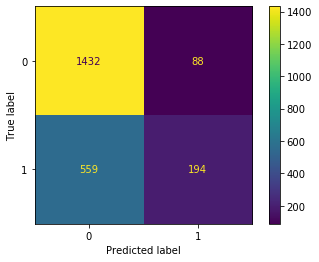

In [111]:
eval_model_vectorized_text(tfidf, nb, X_train, X_test, y_train, y_test)
# still overfit, but better
# precision up 0.13

#### Model 4: Naive Bayes + TF-IDF (More Word Removal)<a id="Model_4"></a>

In [112]:
# Instantiating the TF-IDF vectorizer
tfidf_80 = TfidfVectorizer(max_df = .8, # removes words that appear in more than 80% of docs
                           min_df = 2,
                           use_idf=True) 

Train Scores
Accuracy:0.797741273100616
Precision:0.8953271028037383
Precision Mean Cross Val 3-Fold: 0.6750635989201162
F1 Score:0.5814871016691958
--------
Test Scores
Accuracy:0.7153541575010999
Precision:0.6879432624113475
Precision Mean Cross Val 3-Fold: 0.6750635989201162
F1 Score:0.3748792270531401


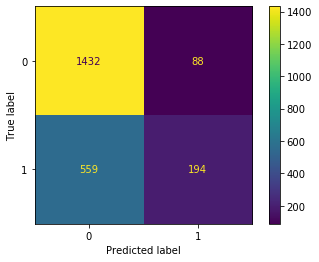

In [113]:
eval_model_vectorized_text(tfidf_80, nb, X_train, X_test, y_train, y_test)
# not impactful

#### Model 5: Random Forest + TF-IDF<a id="Model_5"></a>

In [114]:
# Try RandomForest with class balance (not used in previous models)
rfc = RandomForestClassifier(class_weight='balanced')

Train Scores
Accuracy:0.9608389557054855
Precision:0.9256521739130434
Precision Mean Cross Val 3-Fold: 0.6062299287267194
F1 Score:0.9409944751381216
--------
Test Scores
Accuracy:0.7316322041355038
Precision:0.6234887737478411
Precision Mean Cross Val 3-Fold: 0.6137600931315678
F1 Score:0.5420420420420421


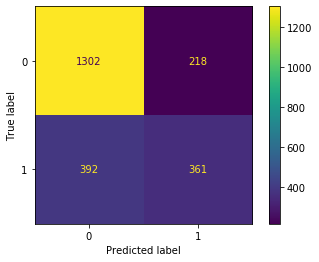

In [115]:
eval_model_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)
# very overfit because not tuned
# higher accuracy, but less precision - NB wins

#### Model 6: SVM + TF-IDF <a id="Model_6"></a>

In [116]:
# Instantiate
svm = SVC()

Train Scores
Accuracy:0.914197711938985
Precision:0.9659090909090909
Precision Mean Cross Val 3-Fold: 0.689828738512949
F1 Score:0.8531994981179423
--------
Test Scores
Accuracy:0.7536295644522657
Precision:0.7371007371007371
Precision Mean Cross Val 3-Fold: 0.689828738512949
F1 Score:0.5172413793103449


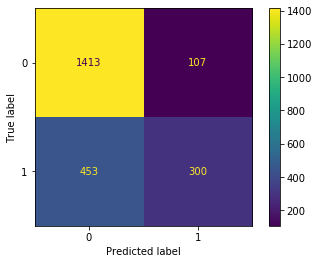

In [117]:
eval_model_vectorized_text(tfidf, svm, X_train, X_test, y_train, y_test)
# overfit, but higher accuracy and similar precision
# move ahead to tune

### Tuning SVM

In [118]:
# Base ranges
C_range = np.array([0.1, 1, 10])
gamma_range = np.array([0.1, 1, 100])
param_grid = dict(gamma=gamma_range, C=C_range)
clfs = []

# Create a loop that builds a model for each  combinations
for C in C_range:
    for gamma in gamma_range:
        clf = SVC(C=C, gamma=gamma)
        clfs.append(clf)

In [119]:
# Go through CLFs and get high level scores (is it overfit? as well as test accuracy and precision scores)
for clf in clfs:
    print(clf)
    X_train_transformed = tfidf.fit_transform(X_train) # learning corpus of training data (holistic)
    X_test_transformed = tfidf.transform(X_test) # new words only in test set won't impact
    clf.fit(X_train_transformed, y_train)
    train_preds = clf.predict(X_train_transformed)
    test_preds = clf.predict(X_test_transformed)
    train_v_test_acc = accuracy_score(y_train, train_preds) - accuracy_score(y_test, test_preds)
    print(f'Train versus Test Accuracy Diff: {train_v_test_acc}')
    test_acc_score = accuracy_score(y_test, test_preds)
    print(f'Test Accuracy Score: {test_acc_score}')
    test_prec_score = precision_score(y_test, test_preds)
    print(f'Test Precision Score: {test_prec_score}')
    print('-----------------------')

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Train versus Test Accuracy Diff: 0.004938210582814517
Test Accuracy Score: 0.6687197536295645
Test Precision Score: 0.0
-----------------------
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train versus Test Accuracy Diff: 0.005672208745334917
Test Accuracy Score: 0.6731192256929168
Test Precision Score: 1.0
-----------------------
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Train versus Test Accuracy Diff: 0.005525086476275809
Test Accuracy Score: 0.6700395952485702
Test Precision Score: 1.0
-----------------------
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Train versus Test Accuracy Diff: 0.016235587663771867
Test Accuracy Score: 0.6942366915970084
Test Precision Score: 0.9142857142857143
-----------------------
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=N

#### Model 7: Tuned SVM + TF-IDF <a id="Model_7"></a>
Winning model

In [120]:
svm_tuned = SVC(C=1.0, gamma=0.1, random_state=42)

Train Scores
Accuracy:0.7104722792607803
Precision:0.8958990536277602
Precision Mean Cross Val 3-Fold: 0.8606423338566196
F1 Score:0.22344610542879623
--------
Test Scores
Accuracy:0.6942366915970084
Precision:0.9142857142857143
Precision Mean Cross Val 3-Fold: 0.8606423338566196
F1 Score:0.15552855407047386


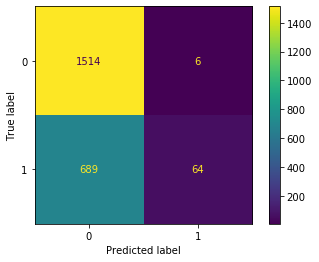

In [121]:
eval_model_vectorized_text(tfidf, svm_tuned, X_train, X_test, y_train, y_test)
# slightly overfit
# Accuracy slightly better than random guess
# Very high precision

## Conclusion

The final model using SVC produced an accuracy score slightly higher than a baseline random guess at 69%, and more importantly a very high precision score at 91% with a mean 3-fold cross validation score of 87%. The F1 score was extremely low at 14%, further proving this model's pure focus on the precision metric versus recall.

This is a great result for this dataset, but there are key ways in which it can be improved and further iterated upon.

#### Recommendations<a id="REC"></a>

On the business side, the team should get clear on vision for internal platform development in order to help guide specific model development beyond this test run. Additionally there should be consideration of investment in resources and timing for R&D around additional uses of this upfront data investment.

From the data perspective, as seen in the wordclouds of unique tokens of positive versus neutral/negative, 2-5 tweets with a unique word made it more influential. This points to the need for more data to train the model accurately. Thus, this model should be scaled by scraping Twitter utilizing hashtags of the events to get relevant tweets for SXSW in years past. The business will need to invest in the same service to label these tweet sentiments for model training purposes as well.
   

#### Future Work<a id="FW"></a>

This model baseline can be further invested in through more expansive scaling which could be accomplished by scraping tweets for additional events our clients/brands are represented at. Testing could include building models by event and/or as a whole depending on fit for business goals of internal platform

If business decided to prioritize and invest additional R&D resources mentioned in the recommendations section, future iterations of modeling still aiming for high precision, but with a focus on utilizing a more interpretable model type. This approach would aid in understanding the specific characteristics of positive sentiment within tweet language. The ability to deep dive into these results could be applied better at a strategic level to plan what to invest in for future events for positive attendee experiences and positive public press for brands.